In [2]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 7.5 MB/s 
     |████████████████████████████████| 3.3 MB 42.4 MB/s 
     |████████████████████████████████| 636 kB 53.8 MB/s 
     |████████████████████████████████| 895 kB 54.3 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ModuleNotFoundError: No module named 'sklearn'

In [2]:
df = pd.read_csv("twitter_user_demo.csv")
df.head()

,tid,uid,dialect,tweet,ND_label
0,204661968144039939,40962780,white,Revamped my workout...im going to be feeling i...,0
1,674984980238340097,201130894,white,RT <USER>_House: On the 8th Day of Christmas H...,0
2,691037123638607873,3022079691,white,RT @RockGrumbler: And it painted Tom Kalinske ...,0
3,534878239403958272,30612357,aa,"Can I buy the ""I'm tired of starter pack memes...",0
4,579829791781605376,2371128043,white,@FoodNetwork #cutthroatkitchen ????? holla...,0


In [3]:
df.shape

(12099, 5)

In [4]:
df.info

<bound method DataFrame.info of                       tid         uid dialect  \
0      204661968144039939    40962780   white   
1      674984980238340097   201130894   white   
2      691037123638607873  3022079691   white   
3      534878239403958272    30612357      aa   
4      579829791781605376  2371128043   white   
...                   ...         ...     ...   
12094  254041364612923393   261948686   white   
12095  170583965864955904   222886324   white   
12096  642853553921331200    72693417      aa   
12097  289026359018270721   742047162   white   
12098  722016526329606144    86512669   white   

                                                   tweet  ND_label  
0      Revamped my workout...im going to be feeling i...         0  
1      RT <USER>_House: On the 8th Day of Christmas H...         0  
2      RT @RockGrumbler: And it painted Tom Kalinske ...         0  
3      Can I buy the "I'm tired of starter pack memes...         0  
4      @FoodNetwork   #cutthroatki

C:\Users\stwan\Miniconda3\envs\GPT_Dialect\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


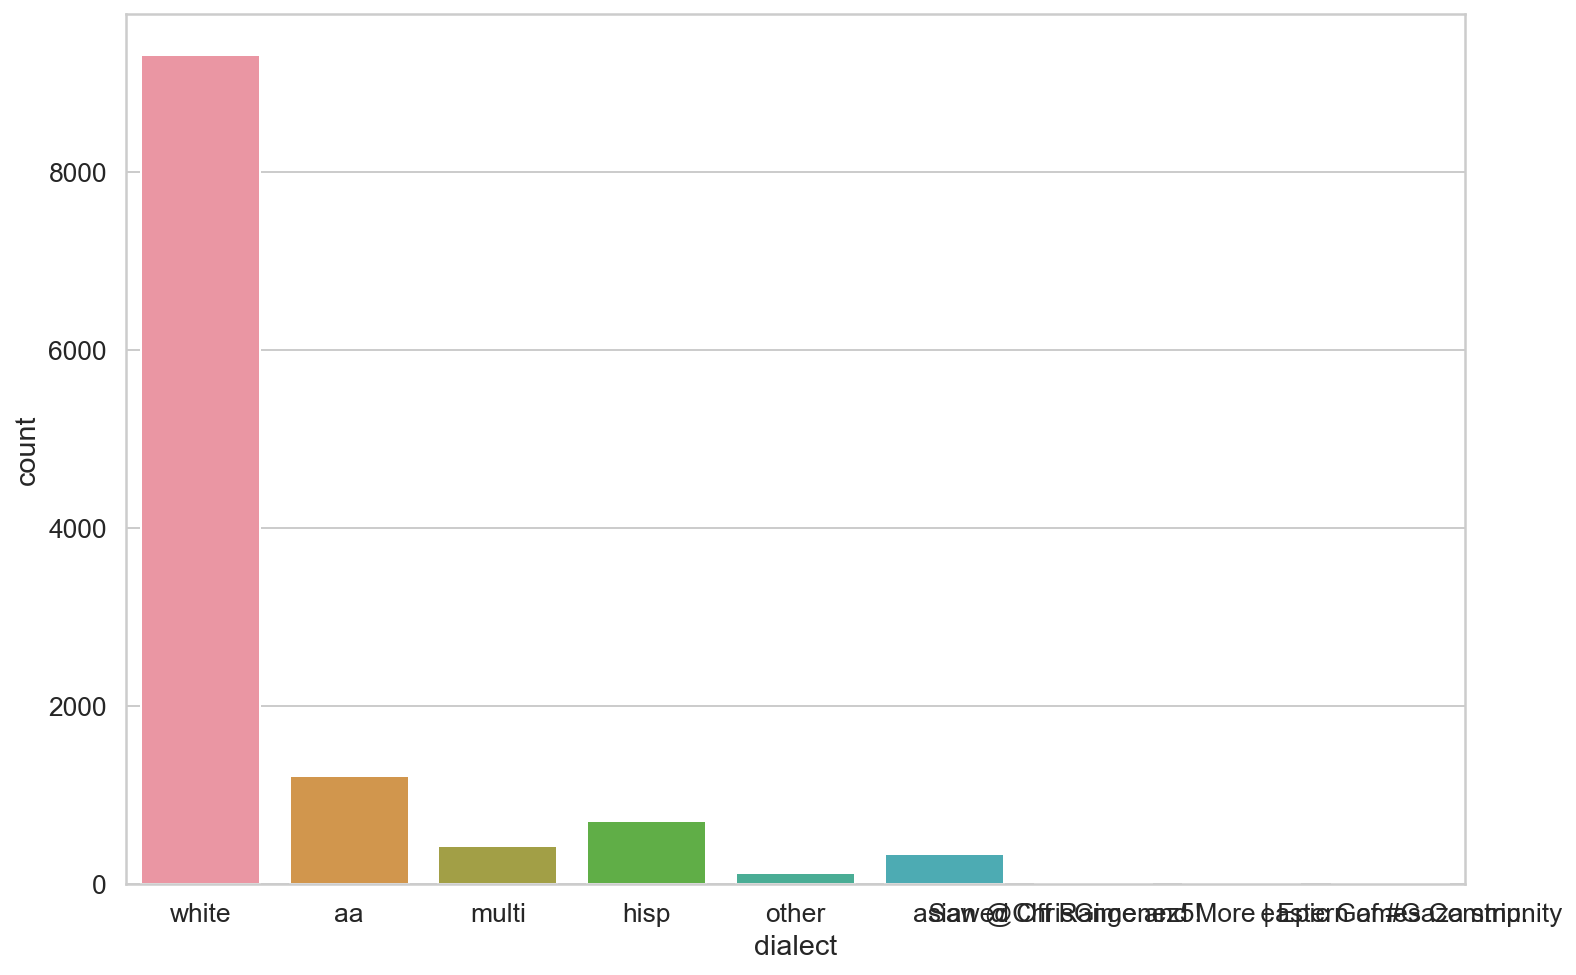

In [5]:
sns.countplot(df.dialect)
plt.xlabel('dialect');

In [6]:
def to_dialect_id(dialect_type):
  if dialect_type == "aa":
    return 0
  elif dialect_type == "asian":
    return 1
  elif dialect_type == "hisp":
    return 2
  elif dialect_type == "multi":
    return 3
  elif dialect_type == "other":
    return 4
  elif dialect_type == "white":
    return 5
  else:
    return 6

In [7]:
class_names = ["aa", "asian", "hisp", "multi", "other", "white", "else"]

In [8]:
df['dialect_id'] = df.dialect.apply(to_dialect_id)

## Data Preprocessing

In [9]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

## Choosing Sequence Length

C:\Users\stwan\Miniconda3\envs\GPT_Dialect\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


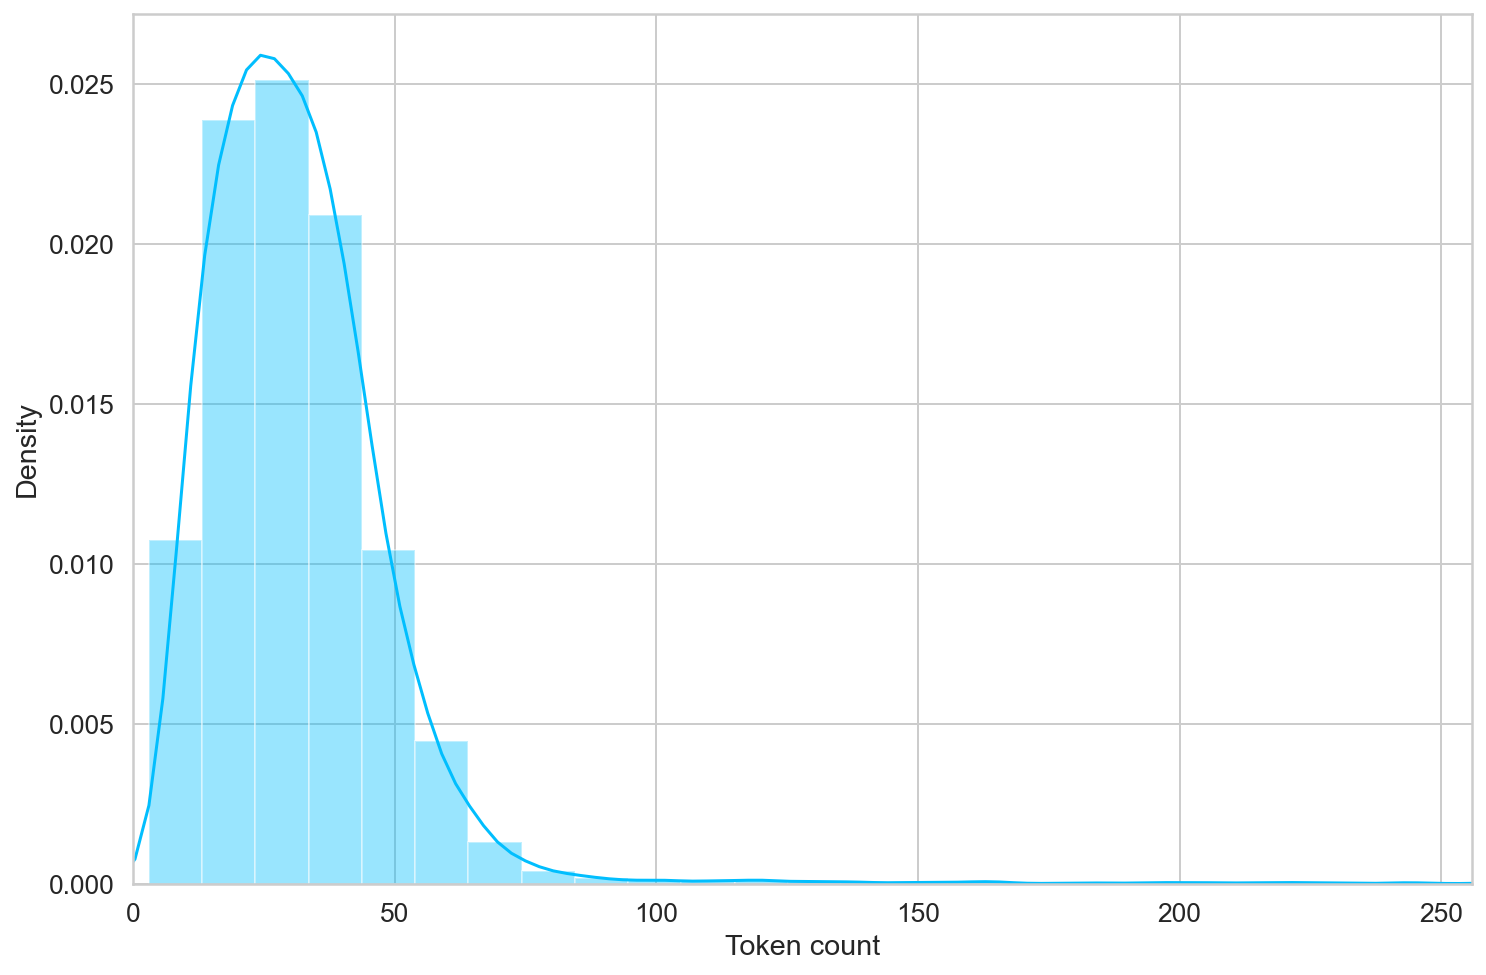

In [11]:
token_lens = []
for txt in df.tweet:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

## Create a Dataset

In [ ]:
class DialectDataset(Dataset):
    
    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweets = str(self.tweets[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            tweets,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
    
        return {
            'tweets_text': tweets,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [13]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [14]:
df_train.shape, df_val.shape, df_test.shape

((10889, 6), (605, 6), (605, 6))

In [15]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = DialectDataset(
        tweets=df.tweet.to_numpy(),
        targets=df.dialect_id.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
        )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
        )

In [16]:
BATCH_SIZE = 16
MAX_LEN = 128
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

## Create Model

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class DialectClassifier(nn.Module):

    def __init__(self, n_classes):
        super(DialectClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        pooled_output = output.pooler_output
        output = self.out(pooled_output)
        return self.softmax(output)

In [ ]:
model = DialectClassifier(len(class_names))
model = model.to(device)
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
model(input_ids, attention_mask)